In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score,precision_score, confusion_matrix, accuracy_score,classification_report
import warnings
warnings.filterwarnings("ignore")


In [122]:
df = pd.read_excel('Rating_Prediction.xlsx')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,Review,Rating
0,Value for money,4
1,Good Good,4
2,Nice led TV,4
3,Very good,4
4,Processing very slow All thing is good but pro...,5


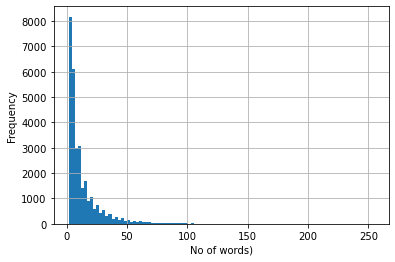

In [123]:
words_per_review = df.Review.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('No of words)')
plt.ylabel('Frequency')
plt.show()

In [124]:
words_per_review.mean()

13.488031521917584

In [125]:
words_per_review.skew()

3.410095280467375

In [126]:
df['Rating'].value_counts()

5    14748
4     8199
1     3405
3     2875
2     1228
Name: Rating, dtype: int64

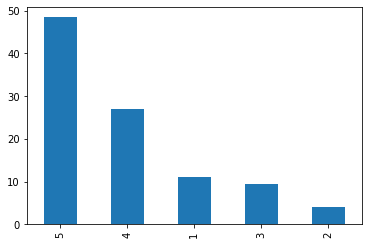

In [127]:
Percentge = df['Rating'].value_counts()/len(df['Rating']) * 100
Percentge.plot.bar()
plt.show()

In [128]:
df1 = df[df['Rating']==1][0:1228]
df2 = df[df['Rating']==2][0:1228]
df3 = df[df['Rating']==3][0:1228]
df4 = df[df['Rating']==4][0:1228]
df5 = df[df['Rating']==5][0:1228]

In [153]:
df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)

<AxesSubplot:>

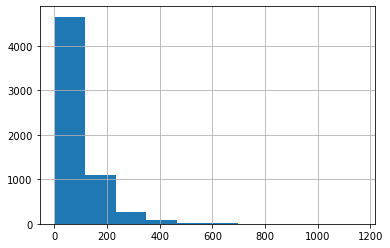

In [155]:
df['char_length']=df['Review'].apply(len)
df['char_length'].hist()

In [157]:
def wl(text):
    return len(text.split(" "))
df['word_length']=df['Review'].apply(wl)

In [163]:
 wl('I am a good boy')

5

<AxesSubplot:>

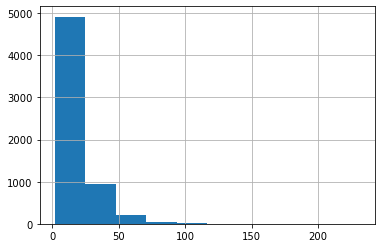

In [159]:
df['word_length'].hist()

<AxesSubplot:xlabel='char_length', ylabel='word_length'>

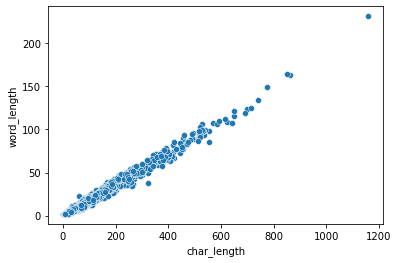

In [160]:
sns.scatterplot(x='char_length',y='word_length',data=df)

In [161]:
df['unique_word_count'] =df['Review'].apply(lambda x: len(set(str(x).split())))

<AxesSubplot:>

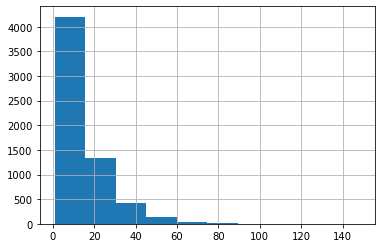

In [162]:
df['unique_word_count'].hist()

<AxesSubplot:xlabel='char_length', ylabel='unique_word_count'>

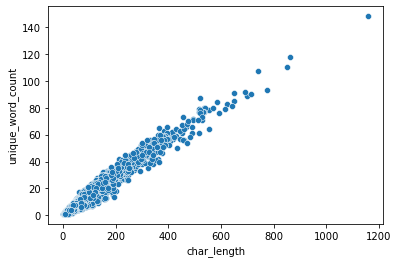

In [164]:
sns.scatterplot(x='char_length',y='unique_word_count',data=df)

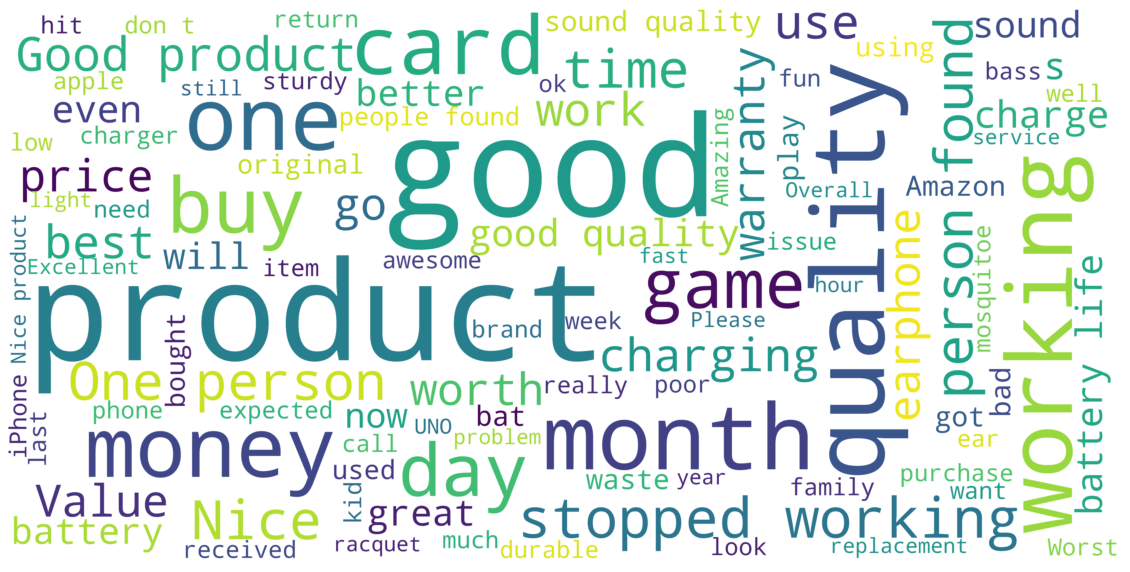

In [16]:
word_cloud_text = ''.join(df['Review'])

wordcloud = WordCloud(max_font_size=100,
                      max_words=100,
                      background_color="white",
                      scale = 10,
                      width=800,
                      height=400
                     ).generate(word_cloud_text)

plt.figure(figsize = (20,20))
plt.imshow(wordcloud, 
           interpolation="bilinear") 
plt.axis("off")
plt.show()

In [130]:
df['Review_lower'] = df['Review'].str.lower()

In [131]:
from nltk import word_tokenize
token_lists = [word_tokenize(i) for i in df['Review']]
tokens = [k for j in token_lists for k in j]
print("No of words before lower case",len(set(tokens)))


token_lists_lower = [word_tokenize(i) for i in df['Review_lower']]
tokens_lower = [k for j in token_lists_lower for k in j]
print("No of words after lower case",len(set(tokens_lower)))

No of words before lower case 7390
No of words after lower case 5878


In [132]:
df['Review_old'] = df['Review_lower'].copy()

In [133]:
df['Review_lower'] = df['Review_lower'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [134]:
print("Before punctions and special characters")
print(df['Review_old'][10])
print("\n- After punctions and special characters")
print(df['Review_lower'][10])

Before punctions and special characters
received only half cards. 

- After punctions and special characters
received only half cards  


In [135]:
from nltk.corpus import stopwords
eng_stop_words = stopwords.words('english')

In [136]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = df['Review_lower'][10]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('Original Sentence\n', sentence)
print('\nStopwords in the sentence\n', stopword)
print('\nNon-stopwords in the sentence\n', without_stop_words)

Original Sentence
 received only half cards  

Stopwords in the sentence
 ['only']

Non-stopwords in the sentence
 ['received', 'half', 'cards']


In [147]:
def stopwords_removal(stop_words, sentence):
    return [i for i in nltk.word_tokenize(sentence) if i not in stop_words]

df['Review_lower_without_stopword'] = df['Review_lower'].apply(lambda review: stopwords_removal(stop_words, review))
df[['Review_lower_without_stopword','Review_lower']].head()

,Review_lower_without_stopword,Review_lower
0,"[performane, issue, android, boot, slow, funct...",performane issue android boot is slow functio...
1,"[worth, money, gud]",worth money gud
2,"[worst, ever, tv, poor, service, please, dont,...",worst ever tv for poor service please dont pur...
3,"[great, product, pathetic, installation, servi...",great product pathetic installation service w...
4,"[blindly, go, one, plus, anyone, comparing, mi...",blindly go for one plus if anyone comparing be...


In [148]:
df['Review_lower_without_stopword'][0]

['performane', 'issue', 'android', 'boot', 'slow', 'functions', 'slow', 'lags']

In [149]:
df['Review_lower'][0]

'performane issue android boot is slow  functions are slow and lags'

In [138]:
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [139]:
def stemm_terms(row):
    return [lancaster.stem(review) for review in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(review) for review in row]
    
df['review_text_stemm'] = df['Review_lower_without_stopword'].apply(lambda row: stemm_terms(row))
df['review_text_lemm'] = df['Review_lower_without_stopword'].apply(lambda row: lemmatize_terms(row))
df[['Review_lower','review_text_stemm','review_text_lemm']]

,Review_lower,review_text_stemm,review_text_lemm
0,performane issue android boot is slow functio...,"[perform, issu, android, boot, slow, funct, sl...","[performane, issue, android, boot, slow, funct..."
1,worth money gud,"[wor, money, gud]","[worth, money, gud]"
2,worst ever tv for poor service please dont pur...,"[worst, ev, tv, poor, serv, pleas, dont, purch...","[worst, ever, tv, poor, service, please, dont,..."
3,great product pathetic installation service w...,"[gre, produc, pathet, instal, serv, produc, be...","[great, product, pathetic, installation, servi..."
4,blindly go for one plus if anyone comparing be...,"[blind, go, on, plu, anyon, comp, mi, 32, inch...","[blindly, go, one, plus, anyone, comparing, mi..."
...,...,...,...
6135,full marks to product but a big zero to amaz...,"[ful, mark, produc, big, zero, amazon, serv, f...","[full, mark, product, big, zero, amazon, servi..."
6136,genuine product from apple genuine product fro...,"[genuin, produc, appl, genuin, produc, appl, h...","[genuine, product, apple, genuine, product, ap..."
6137,good good,"[good, good]","[good, good]"
6138,great stuff excellent quality,"[gre, stuff, excel, qual]","[great, stuff, excellent, quality]"


In [150]:
df['Review_lower'][0]

'performane issue android boot is slow  functions are slow and lags'

In [151]:
df['review_text_stemm'][0]

['perform', 'issu', 'android', 'boot', 'slow', 'funct', 'slow', 'lag']

In [152]:
df['review_text_lemm'][0]

['performane', 'issue', 'android', 'boot', 'slow', 'function', 'slow', 'lag']

### CountVectorizer

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
X = count.fit_transform(df['Review_lower'])
df_count = pd.DataFrame(X.toarray(), columns = count.get_feature_names())
df_count.head()

,00,000,01,02,03,05,08,0ne,10,100,...,yu,zap,zapper,zapping,zaps,zebronics,zero,zoneminder,zoom,zoomed
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
from nltk import ngrams
bow_count = CountVectorizer(tokenizer= word_tokenize,
                             stop_words=stop_words, 
                             ngram_range=(1,1)) 

bow_data = bow_count.fit_transform(df['Review_lower'])

In [38]:
bow_data

<6140x5015 sparse matrix of type '<class 'numpy.int64'>'
	with 50946 stored elements in Compressed Sparse Row format>

In [44]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    df['Rating'], 
                                                                    test_size = 0.2, 
                                                                    random_state = 0) 

In [46]:
rf = RandomForestClassifier()
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
bnb = BernoulliNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()

In [62]:
model = [LinearSVC,LogisticRegression(solver='lbfgs'),MultinomialNB(),BernoulliNB(),LGBMClassifier(),SGDClassifier()]

In [70]:
def BOWModel(model):
    print(model.__class__.__name__)
    model.fit(X_train_bow,y_train_bow)
    y_pred = model.predict(X_train_bow)
    pred = model.predict(X_test_bow)
    accuracy = accuracy_score(y_test_bow,pred)*100
    print(f"Accuracy Score:", accuracy)
    print("\n")   
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test_bow,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test_bow,pred)}\n")

In [71]:
for model in [lr,svc,bnb,mnb,sgd,rf]:
    BOWModel(model)

LogisticRegression
Accuracy Score: 46.986970684039086


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.52      0.49      0.50       242
           2       0.51      0.46      0.48       230
           3       0.38      0.31      0.34       258
           4       0.35      0.38      0.36       258
           5       0.57      0.73      0.64       240

    accuracy                           0.47      1228
   macro avg       0.47      0.47      0.47      1228
weighted avg       0.46      0.47      0.46      1228

Confusion Matrix : 
 [[118  34  41  35  14]
 [ 41 105  42  34   8]
 [ 48  35  81  61  33]
 [ 19  26  40  98  75]
 [  0   4   9  52 175]]

LinearSVC
Accuracy Score: 44.462540716612374


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.48      0.43      0.46       242
           2       0.45      0.45      0.45       230
           3       0.36      0.26      0.30       258
 

In [77]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
         }

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV
GS =  GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
GS.fit(X_train_bow,y_train_bow)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [79]:
GS.best_estimator_

MultinomialNB()

In [82]:
GS.best_params_

{'alpha': 1.0}

In [85]:
model = MultinomialNB(alpha = 1.0)
model.fit(X_train_bow,y_train_bow)
y_pred = model.predict(X_train_bow)
pred = model.predict(X_test_bow)
accuracy = accuracy_score(y_test_bow,pred)*100
print(f"Accuracy Score:", accuracy)
print("\n")   
print(f"CLASSIFICATION REPORT : \n {classification_report(y_test_bow,pred)}")
print(f"Confusion Matrix : \n {confusion_matrix(y_test_bow,pred)}\n")

Accuracy Score: 49.8371335504886


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.48      0.60      0.53       242
           2       0.58      0.43      0.49       230
           3       0.42      0.31      0.36       258
           4       0.40      0.40      0.40       258
           5       0.60      0.78      0.68       240

    accuracy                           0.50      1228
   macro avg       0.50      0.50      0.49      1228
weighted avg       0.49      0.50      0.49      1228

Confusion Matrix : 
 [[144  20  37  30  11]
 [ 55  98  36  29  12]
 [ 67  28  80  57  26]
 [ 31  15  32 103  77]
 [  2   8   7  36 187]]



### TfidfVectorizer

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,
                               stop_words=stop_words,
                               ngram_range=(1,1))
tfidf_data = tfidf_counts.fit_transform(df['Review_lower'])

In [88]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                    df['Rating'], 
                                                                    test_size = 0.2, 
                                                                    random_state = 0) 

In [89]:
model = [LinearSVC,LogisticRegression(solver='lbfgs'),MultinomialNB(),BernoulliNB(),LGBMClassifier(),SGDClassifier()]

In [90]:
def tfidfModel(model):
    print(model.__class__.__name__)
    model.fit(X_train_tfidf,y_train_tfidf)
    y_pred = model.predict(X_train_tfidf)
    pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test_tfidf,pred)*100
    print(f"Accuracy Score:", accuracy)
    print("\n")   
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test_tfidf,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test_tfidf,pred)}\n")

In [91]:
for model in [lr,svc,bnb,mnb,sgd,rf]:
    tfidfModel(model)

LogisticRegression
Accuracy Score: 47.88273615635179


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.52      0.52      0.52       242
           2       0.50      0.50      0.50       230
           3       0.39      0.34      0.36       258
           4       0.36      0.35      0.36       258
           5       0.60      0.70      0.65       240

    accuracy                           0.48      1228
   macro avg       0.47      0.48      0.48      1228
weighted avg       0.47      0.48      0.47      1228

Confusion Matrix : 
 [[127  37  43  27   8]
 [ 40 114  41  27   8]
 [ 52  43  87  55  21]
 [ 25  23  42  91  77]
 [  1  10   8  52 169]]

LinearSVC
Accuracy Score: 45.84690553745928


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.48      0.46      0.47       242
           2       0.48      0.49      0.49       230
           3       0.39      0.32      0.35       258
   

In [92]:
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
         }

In [93]:
from sklearn.model_selection import train_test_split, GridSearchCV
GS =  GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
GS.fit(X_train_tfidf,y_train_tfidf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}, verbose=5)

In [94]:
GS.best_estimator_

MultinomialNB(alpha=0.5)

In [95]:
GS.best_params_

{'alpha': 0.5}

In [96]:
model = MultinomialNB(alpha = 0.5)
model.fit(X_train_tfidf,y_train_tfidf)
y_pred = model.predict(X_train_tfidf)
pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_tfidf,pred)*100
print(f"Accuracy Score:", accuracy)
print("\n")   
print(f"CLASSIFICATION REPORT : \n {classification_report(y_test_tfidf,pred)}")
print(f"Confusion Matrix : \n {confusion_matrix(y_test_tfidf,pred)}\n")

Accuracy Score: 48.9413680781759


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.48      0.61      0.54       242
           2       0.54      0.46      0.49       230
           3       0.40      0.29      0.34       258
           4       0.40      0.36      0.38       258
           5       0.60      0.75      0.66       240

    accuracy                           0.49      1228
   macro avg       0.48      0.49      0.48      1228
weighted avg       0.48      0.49      0.48      1228

Confusion Matrix : 
 [[148  22  37  25  10]
 [ 54 105  37  23  11]
 [ 69  40  75  50  24]
 [ 34  19  35  93  77]
 [  2  10   5  43 180]]

